In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
fmnist_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fmnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader_mnist = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader_mnist = DataLoader(mnist_test, batch_size=64, shuffle=False)
train_loader_fmnist = DataLoader(fmnist_train, batch_size=64, shuffle=True)
test_loader_fmnist = DataLoader(fmnist_test, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.09MB/s]
100%|██████████| 26.4M/26.4M [00:03<00:00, 8.01MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 131kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.49MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 7.79MB/s]


In [2]:
class ConvNetDualHead(nn.Module):
    def __init__(self):
        super(ConvNetDualHead, self).__init__()
        self.shared = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.flatten = nn.Flatten()
        self.head1 = nn.Linear(64 * 7 * 7, 10)
        self.head2 = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x, head='head1'):
        x = self.shared(x)
        x = self.flatten(x)
        if head == 'head1':
            return self.head1(x)
        else:
            return self.head2(x)

In [3]:
def train_model(model, train_loader, test_loader, optimizer, criterion, device, head='head1', epochs=10):
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, head=head)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images, head=head)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_losses.append(test_loss / len(test_loader))
        acc = 100 * correct / total
        # print(f"[{head}] Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {acc:.2f}%")
    return train_losses, test_losses


In [4]:
model = ConvNetDualHead().to(device)
criterion = nn.CrossEntropyLoss()

# голова 1
optimizer1 = optim.Adam(list(model.shared.parameters()) + list(model.head1.parameters()), lr=0.001)
train1, test1 = train_model(model, train_loader_mnist, test_loader_mnist, optimizer1, criterion, device, head='head1')

# Сохраняем
torch.save({
    'shared': model.shared.state_dict(),
    'head1': model.head1.state_dict(),
    'head2': model.head2.state_dict()
}, 'initial_weights.pth')

# head2 на FashionMNIST, shared заморожен
for param in model.shared.parameters():
    param.requires_grad = False
optimizer2 = optim.Adam(model.head2.parameters(), lr=0.001)
train2, test2 = train_model(model, train_loader_fmnist, test_loader_fmnist, optimizer2, criterion, device, head='head2')

# дообучение head2 и head1 с размороженными shared
for param in model.shared.parameters():
    param.requires_grad = True
optimizer3 = optim.Adam(list(model.shared.parameters()) + list(model.head2.parameters()), lr=0.001)
train3_2, test3_2 = train_model(model, train_loader_fmnist, test_loader_fmnist, optimizer3, criterion, device, head='head2')

# опять head1
optimizer3_h1 = optim.Adam(list(model.shared.parameters()) + list(model.head1.parameters()), lr=0.001)
train3_1, test3_1 = train_model(model, train_loader_mnist, test_loader_mnist, optimizer3_h1, criterion, device, head='head1')

# загрузка сохранённой модели, обучение head2
model.shared.load_state_dict(torch.load('initial_weights.pth')['shared'])
model.head1.load_state_dict(torch.load('initial_weights.pth')['head1'])
model.head2.load_state_dict(torch.load('initial_weights.pth')['head2'])

for param in model.shared.parameters():
    param.requires_grad = True
optimizer4 = optim.Adam(list(model.shared.parameters()) + list(model.head2.parameters()), lr=0.001)
train4_2, test4_2 = train_model(model, train_loader_fmnist, test_loader_fmnist, optimizer4, criterion, device, head='head2')

In [5]:
def plot_learning_curve(train, test, title):
    plt.figure()
    plt.plot(train, label='Train loss')
    plt.plot(test, label='Test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

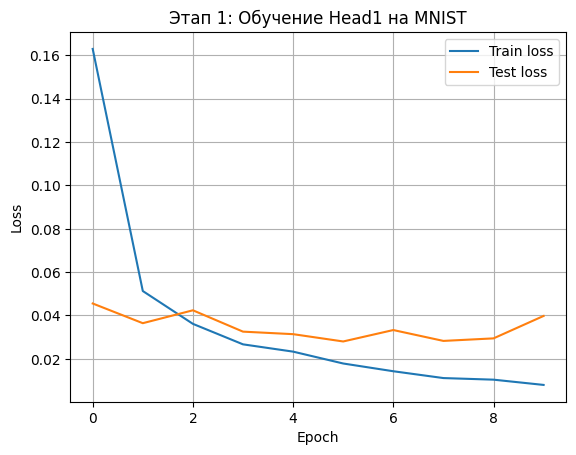

In [6]:
plot_learning_curve(train1, test1, "Обучение Head1 на MNIST")

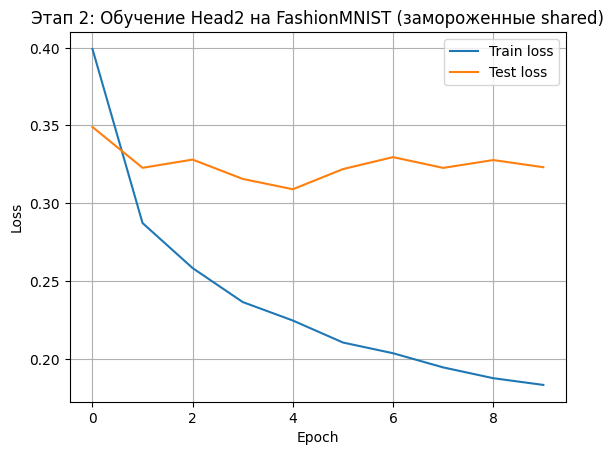

In [7]:
plot_learning_curve(train2, test2, "Обучение Head2 на FashionMNIST (замороженные shared)")

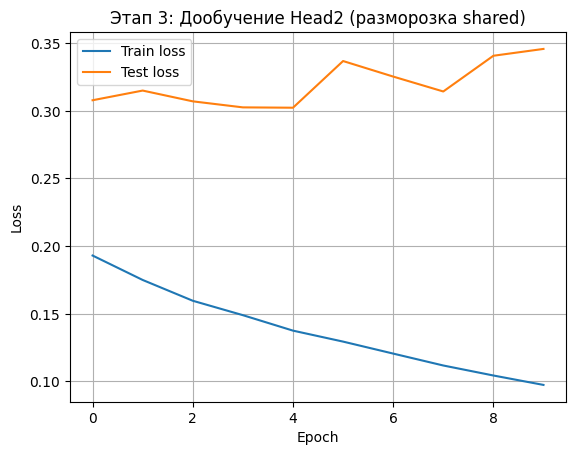

In [8]:
plot_learning_curve(train3_2, test3_2, "Дообучение Head2 (разморозка shared)")

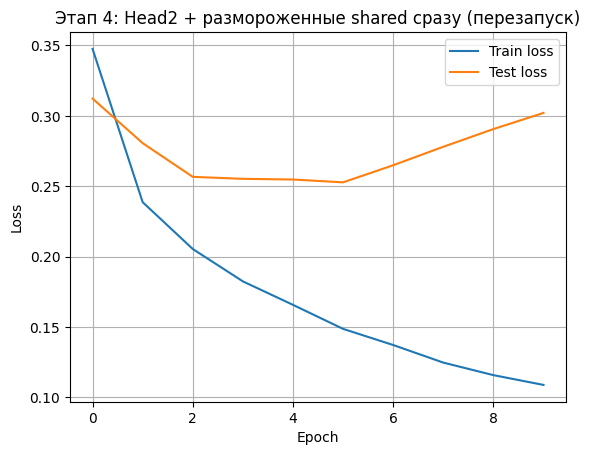

In [9]:
plot_learning_curve(train4_2, test4_2, "Head2 + размороженные shared сразу")

In [13]:
import torch.nn.functional as F

best_images = {}  # (c, t)
model.eval()
with torch.no_grad():
  for images, labels in test_loader_fmnist:
      outputs = model(images, head='head2')
      probs = F.softmax(outputs, dim=1)
      for i in range(images.size(0)):
        c = labels[i].item()
        for t in range(10):
          if c == t:
            continue
          prob_t = probs[i][t].item()
          key = (c, t)
          if key not in best_images or prob_t > best_images[key][1]:
                    best_images[key] = (images[i].cpu(), prob_t)

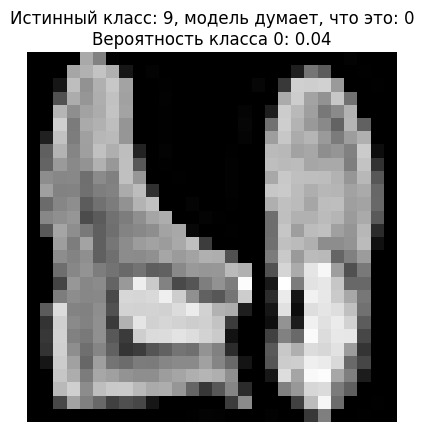

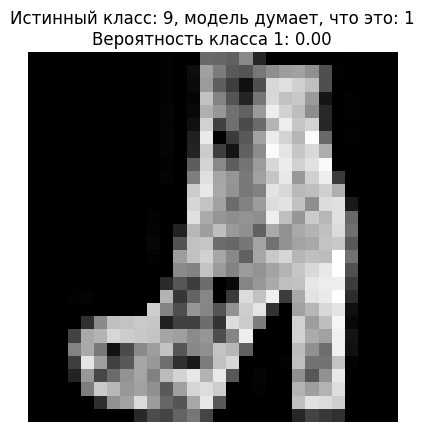

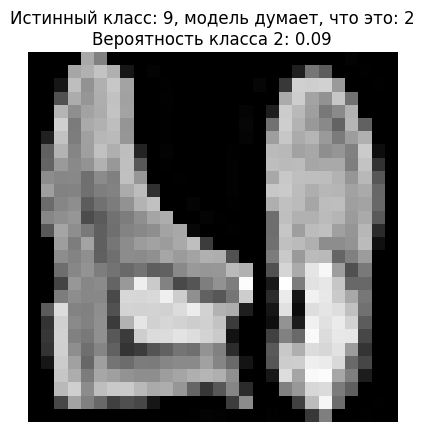

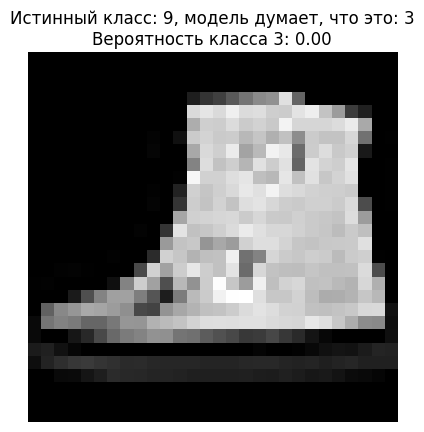

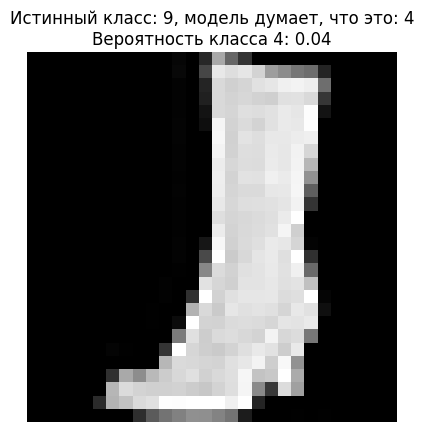

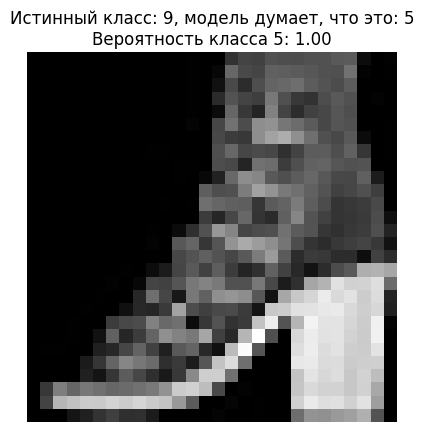

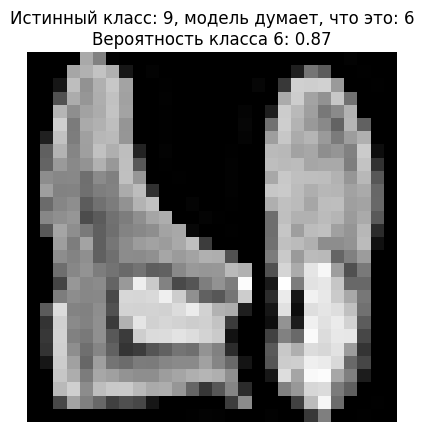

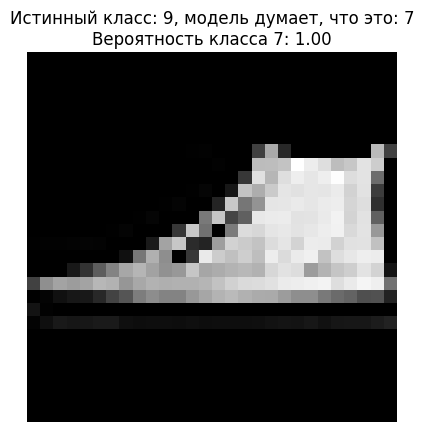

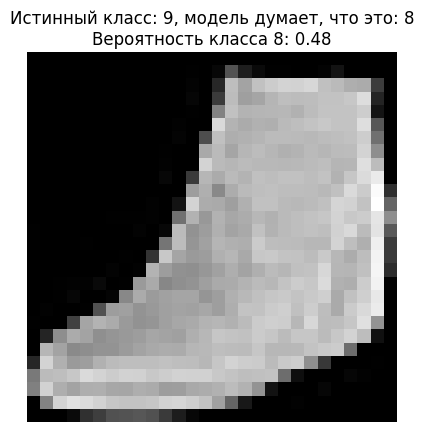

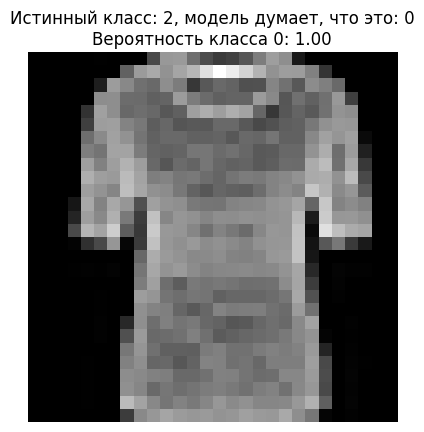

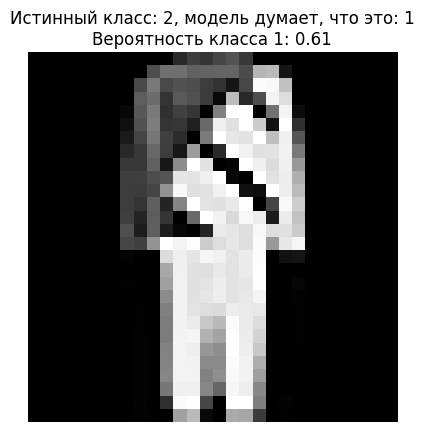

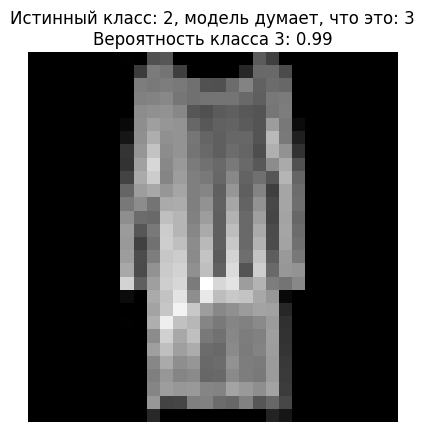

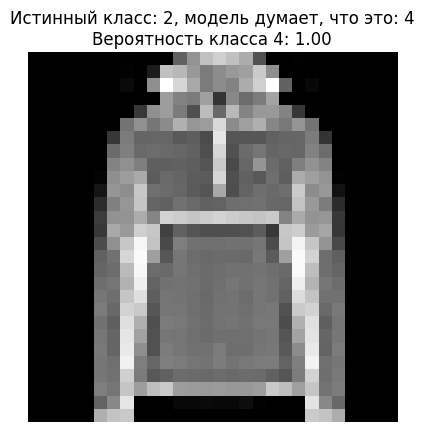

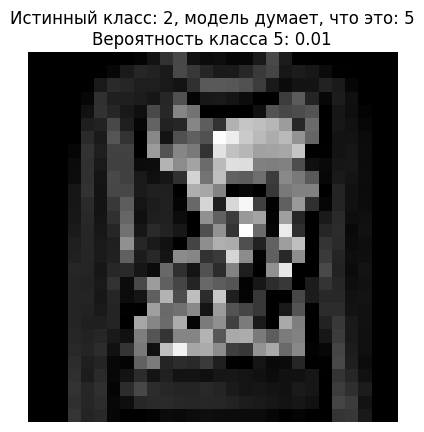

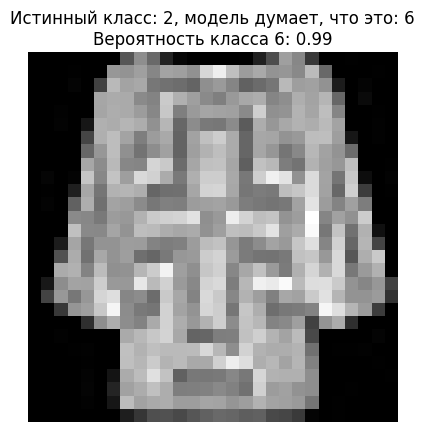

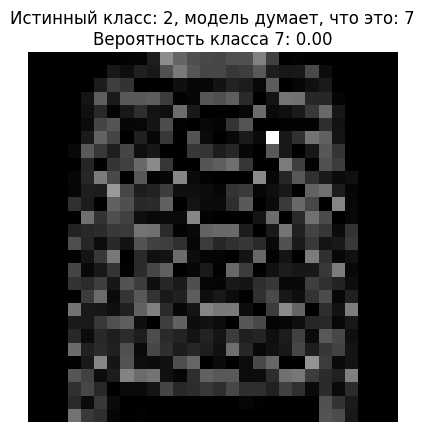

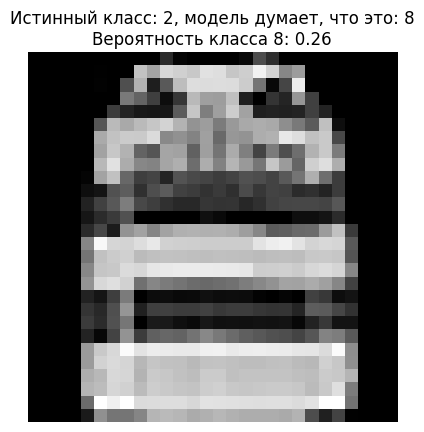

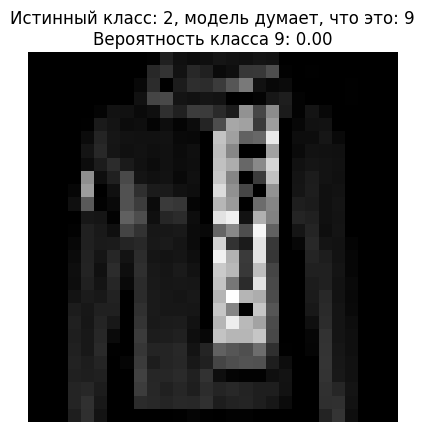

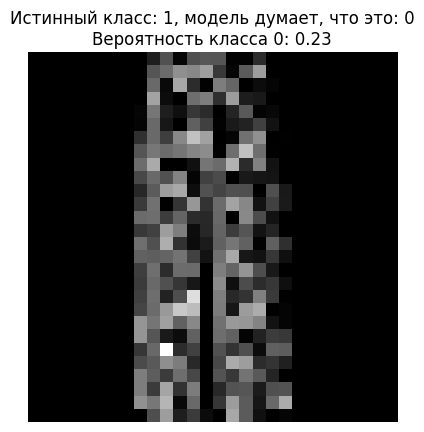

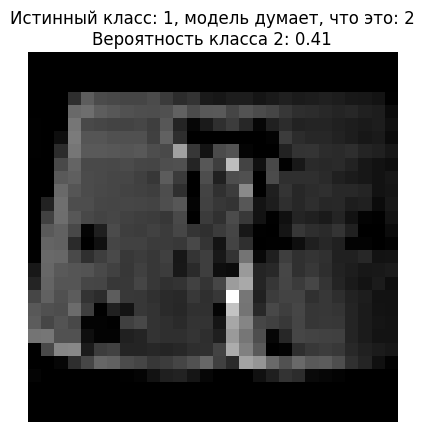

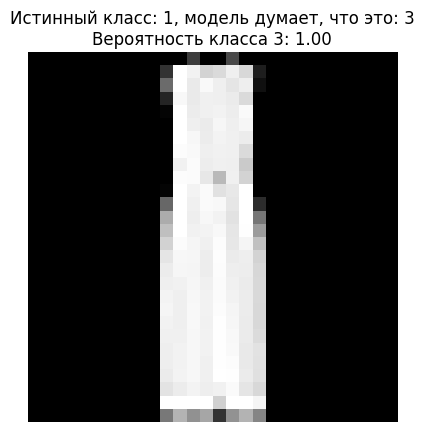

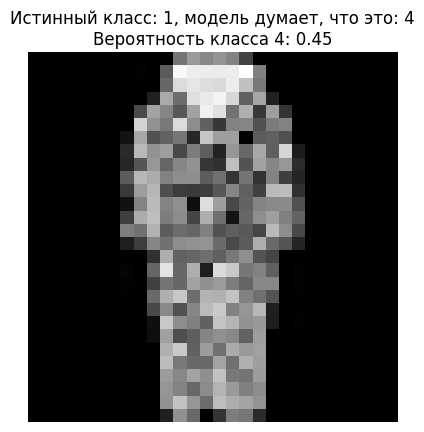

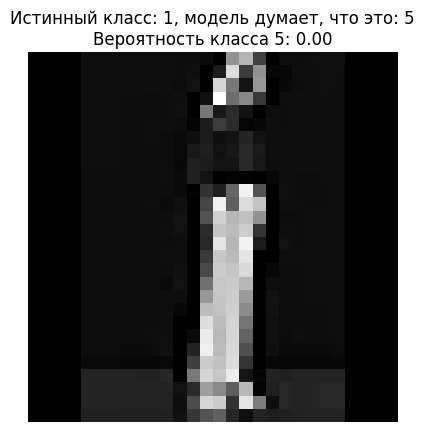

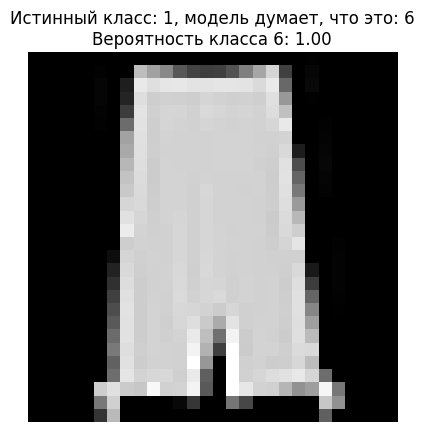

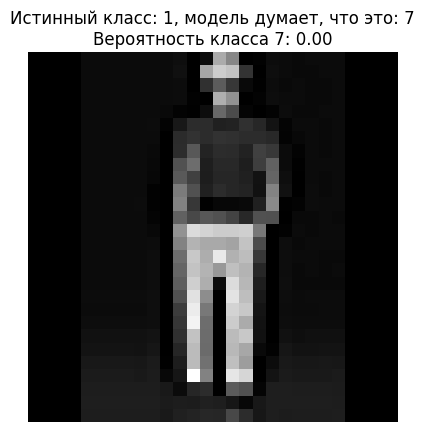

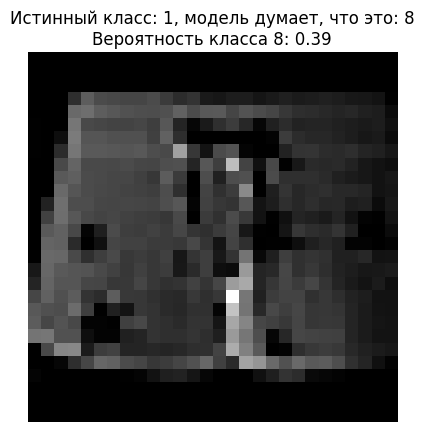

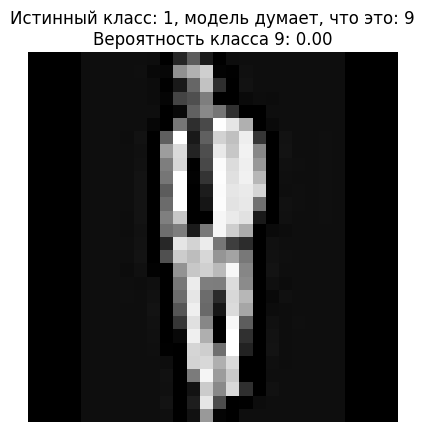

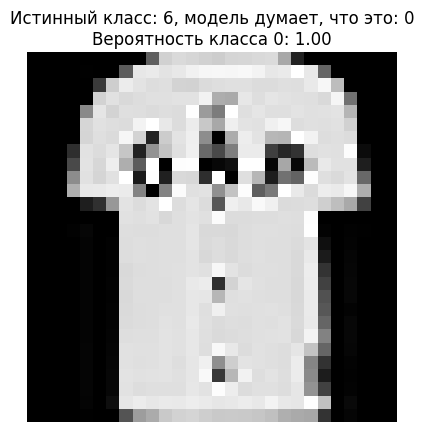

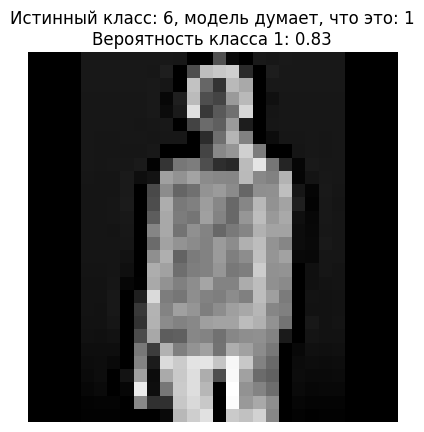

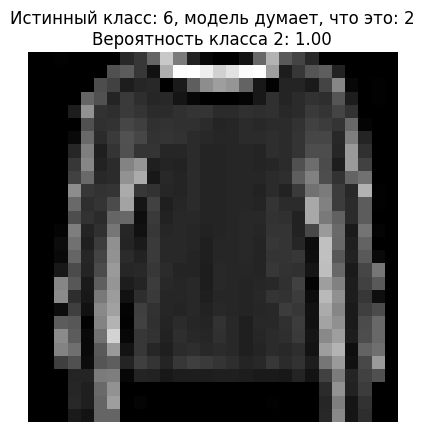

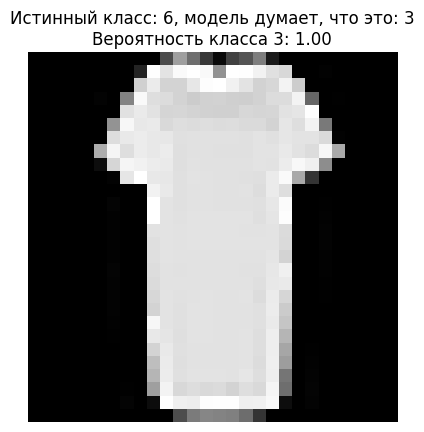

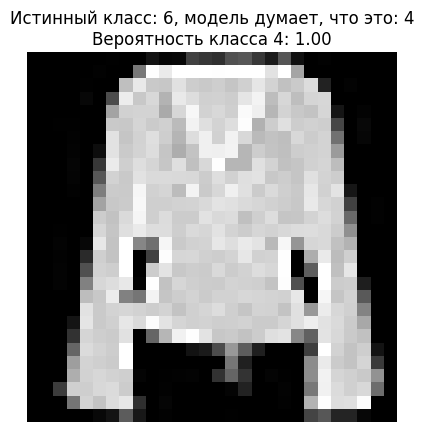

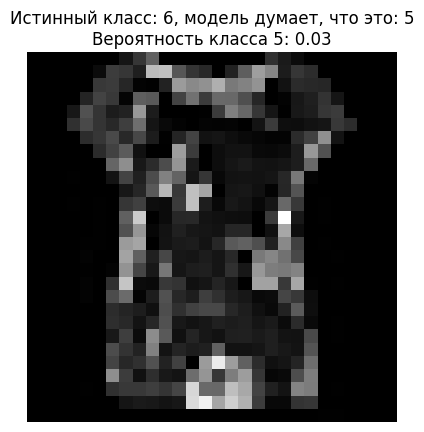

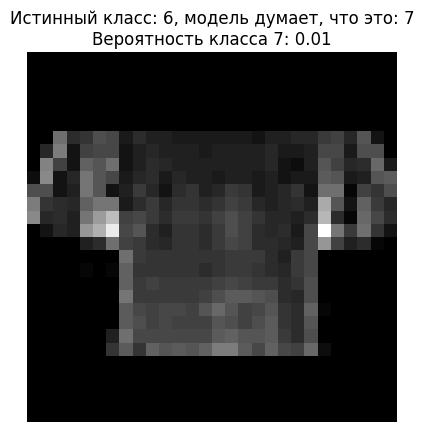

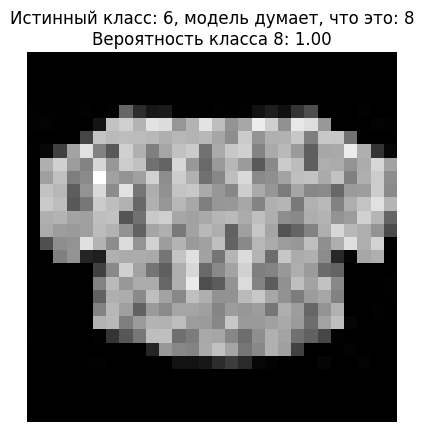

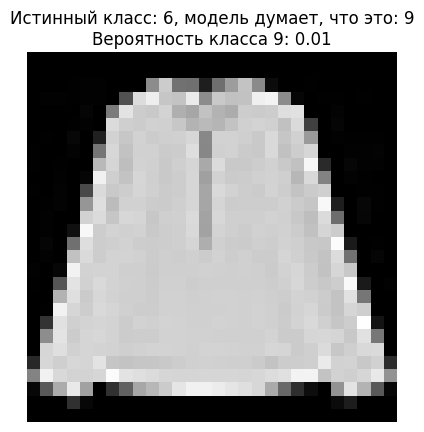

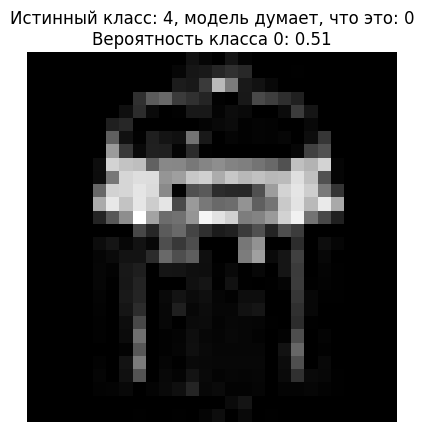

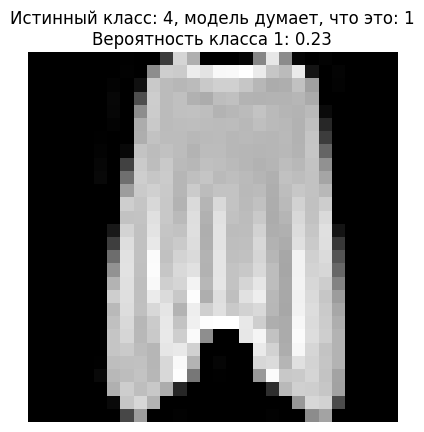

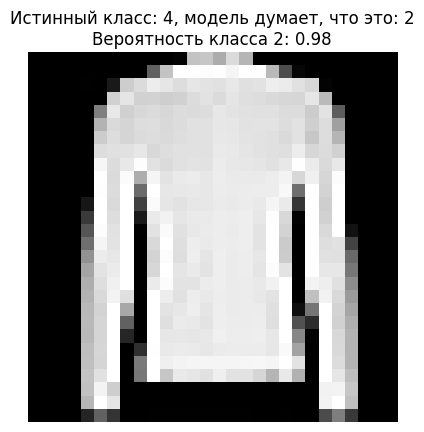

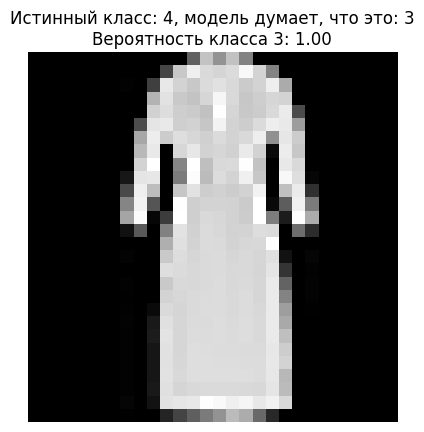

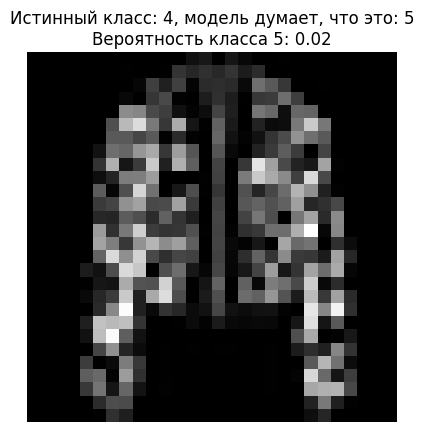

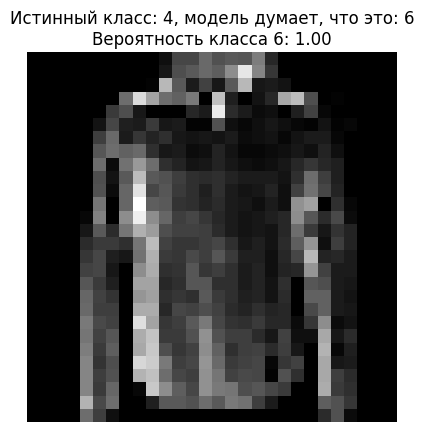

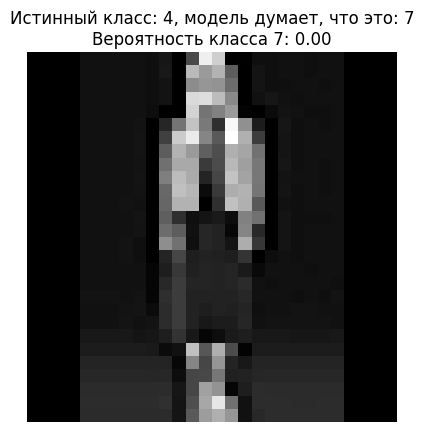

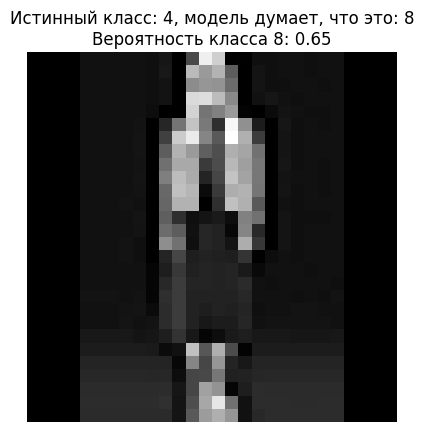

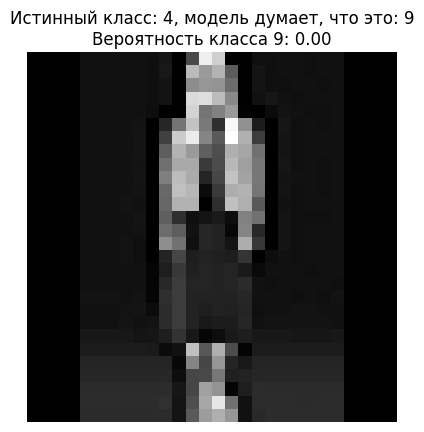

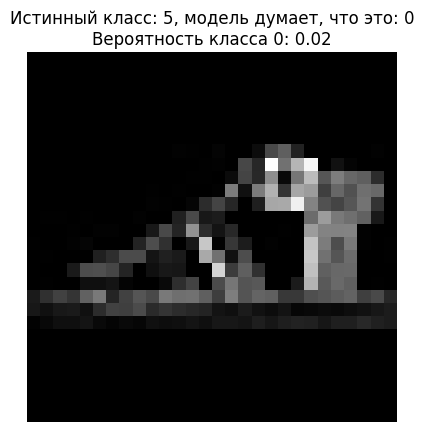

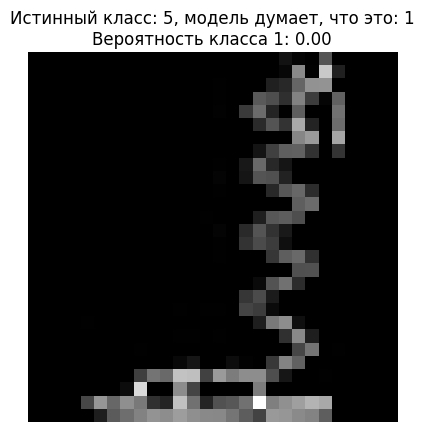

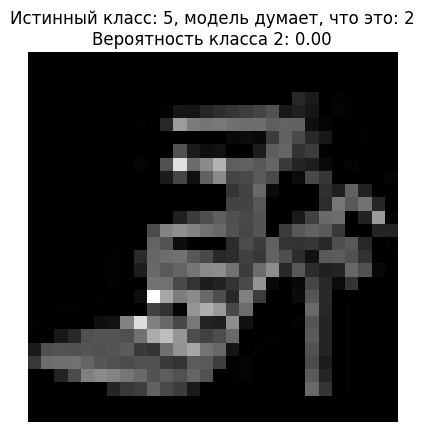

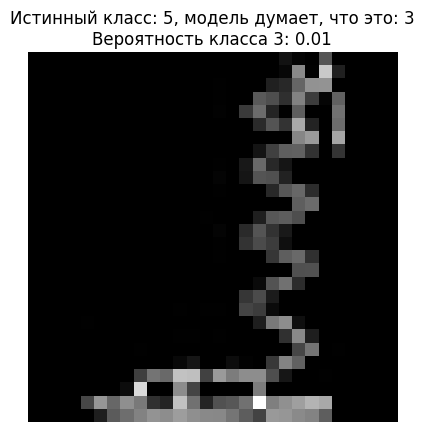

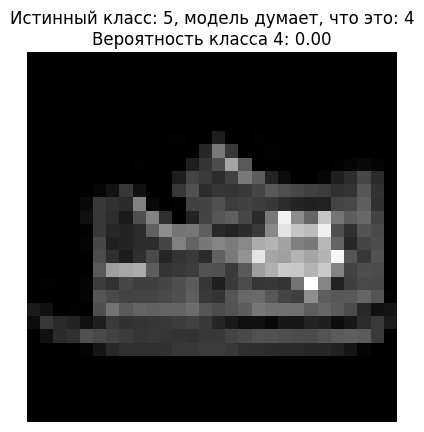

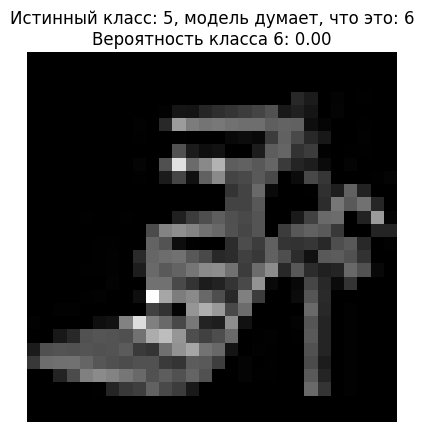

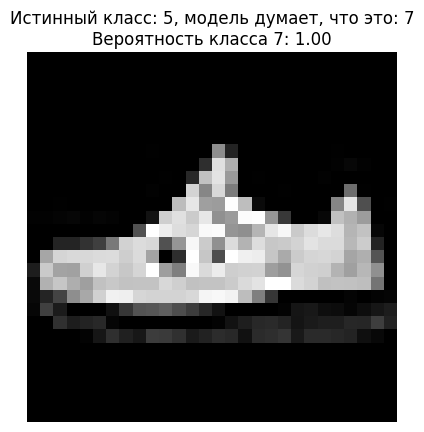

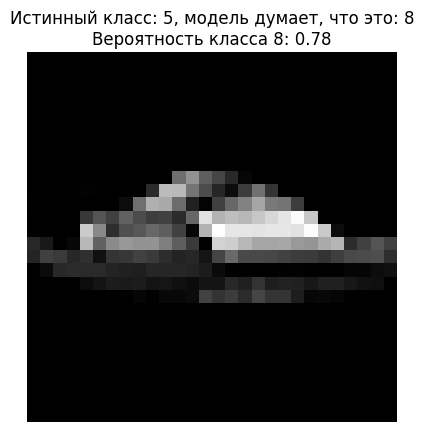

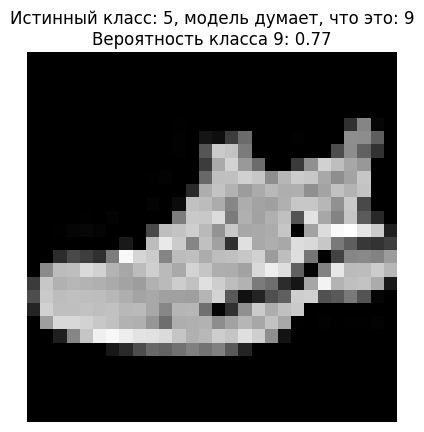

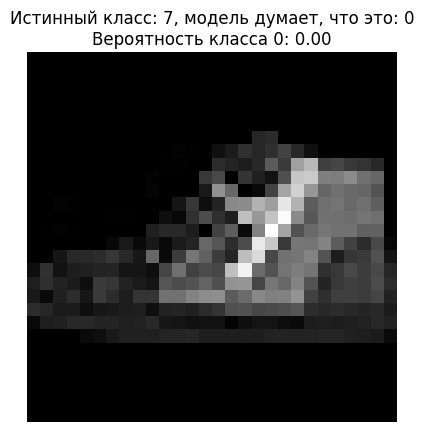

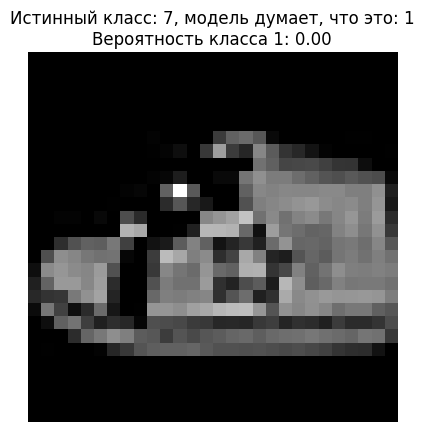

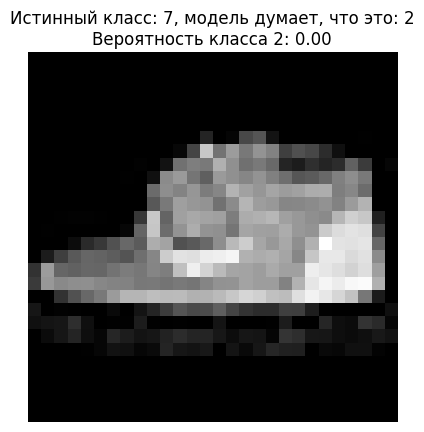

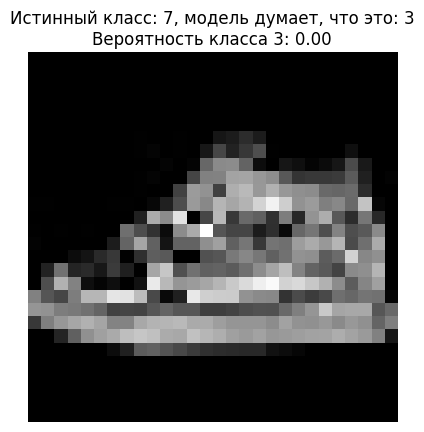

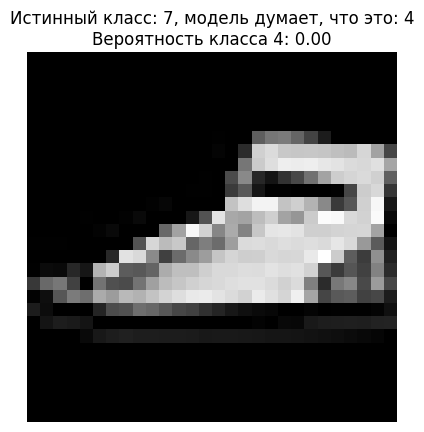

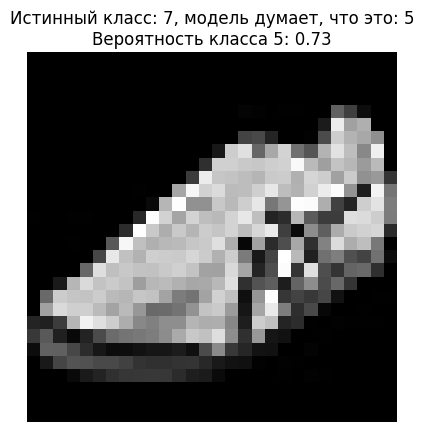

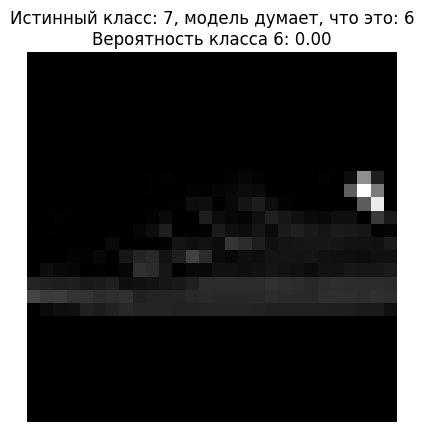

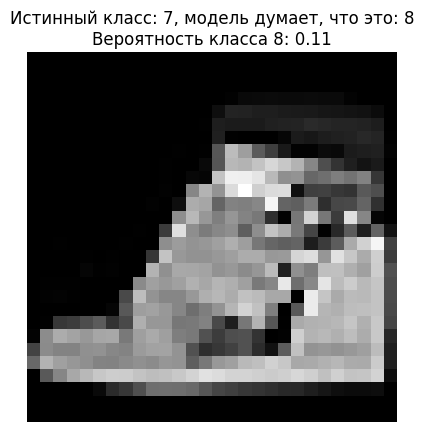

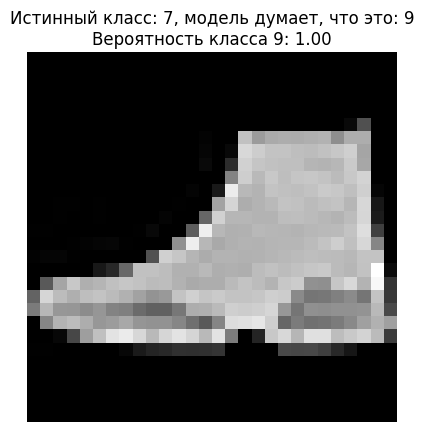

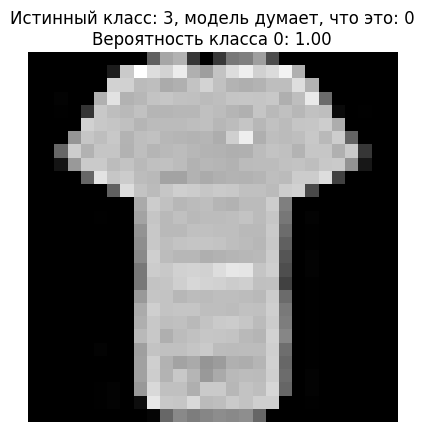

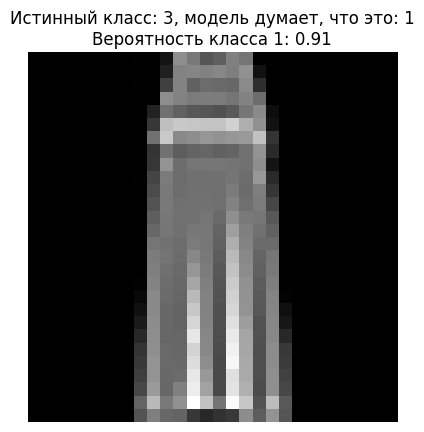

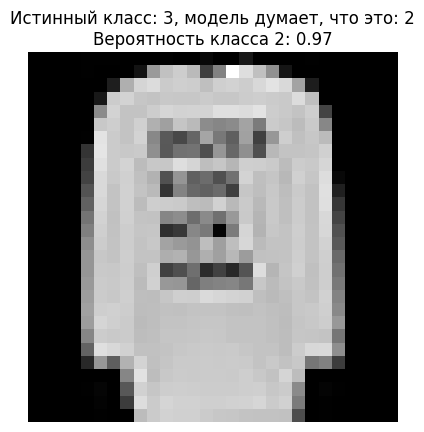

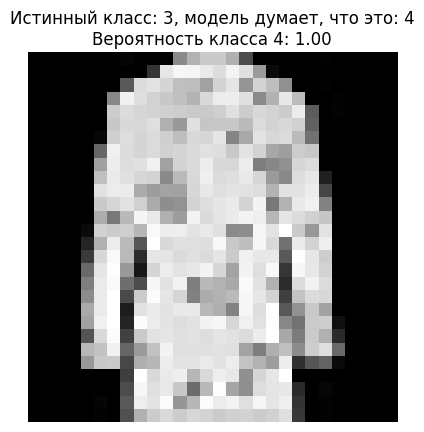

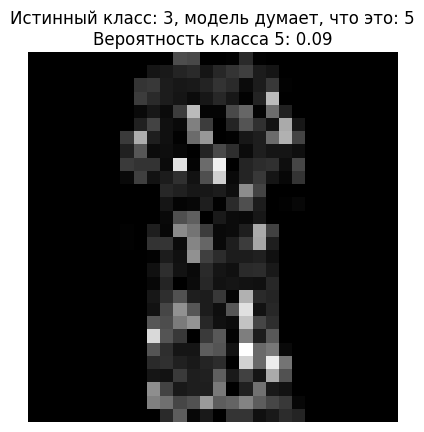

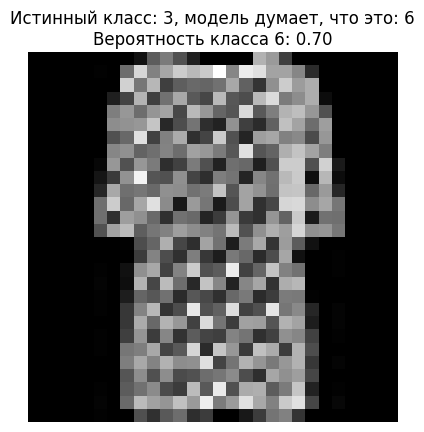

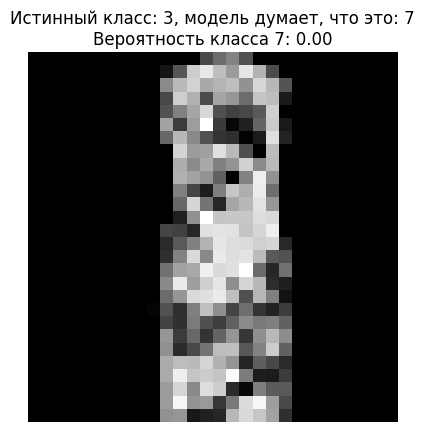

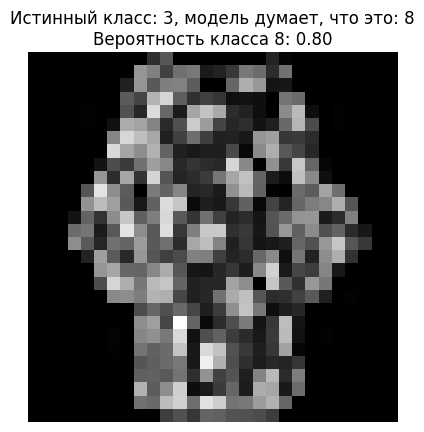

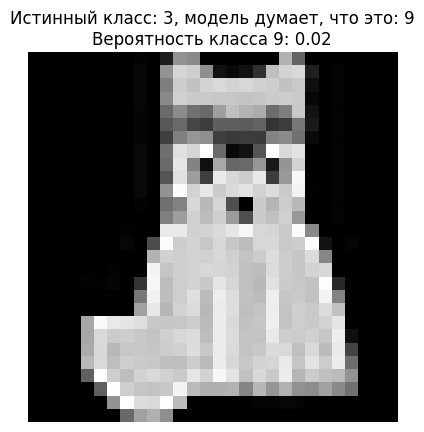

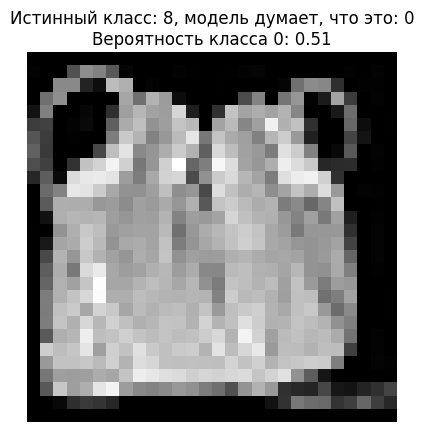

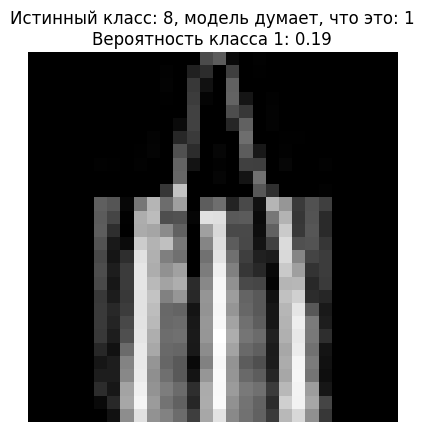

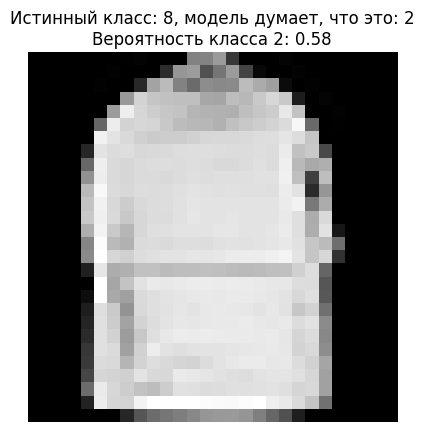

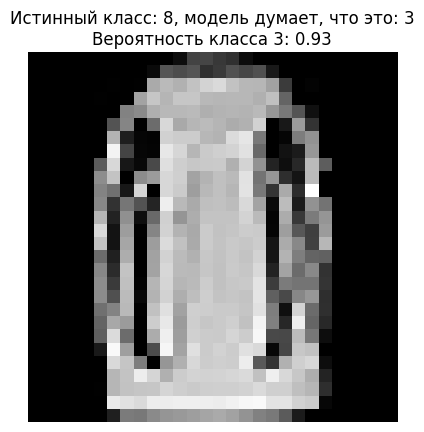

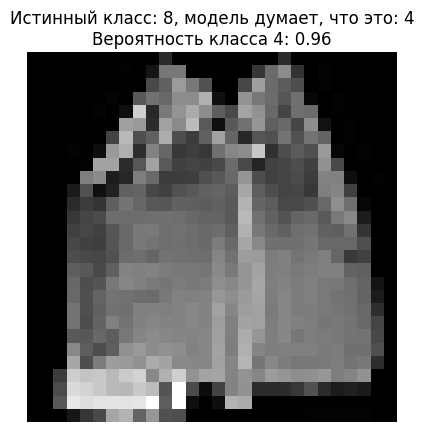

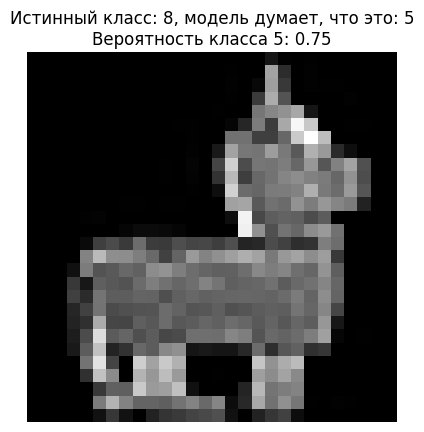

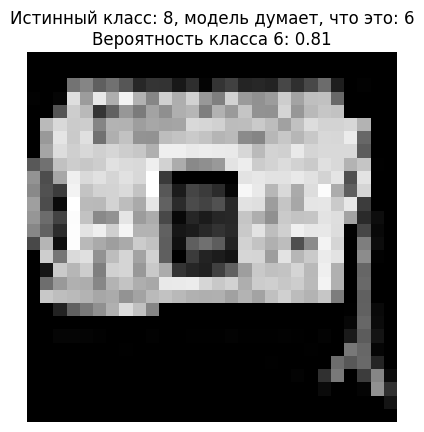

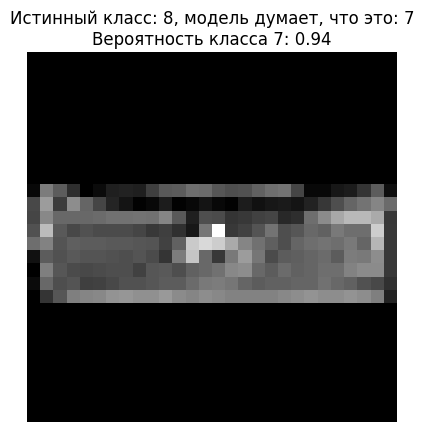

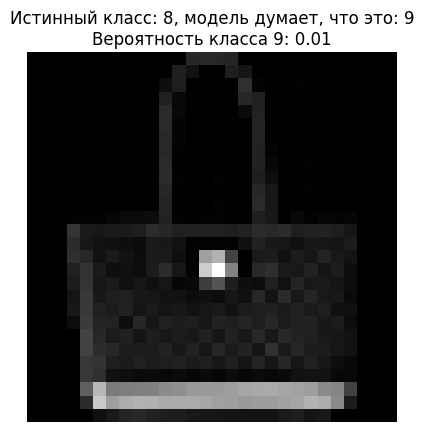

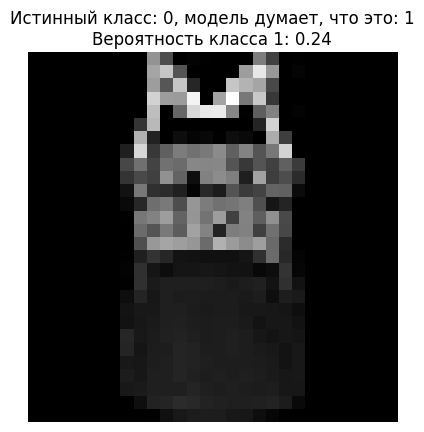

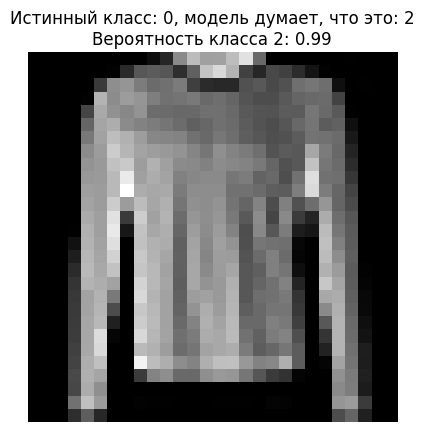

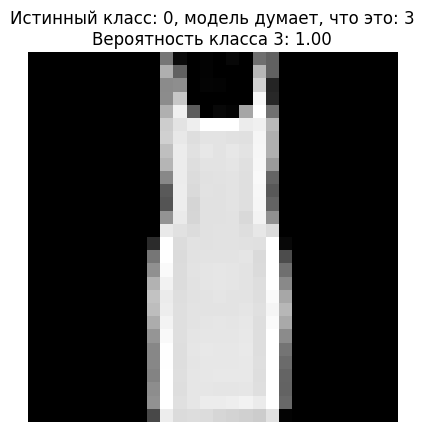

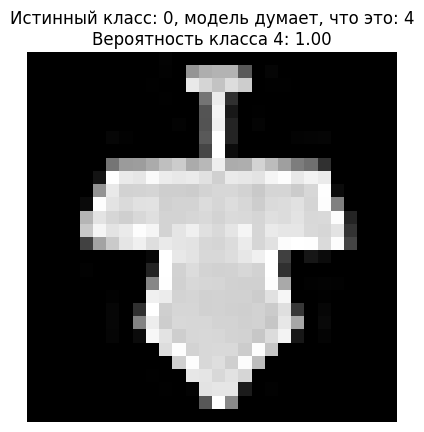

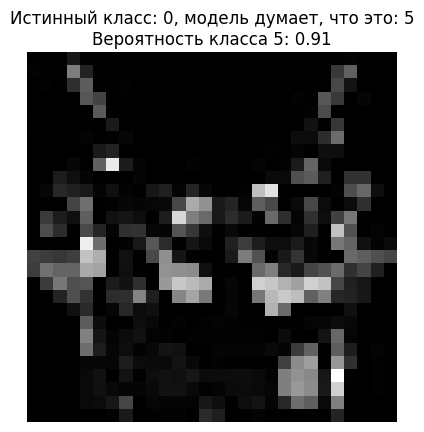

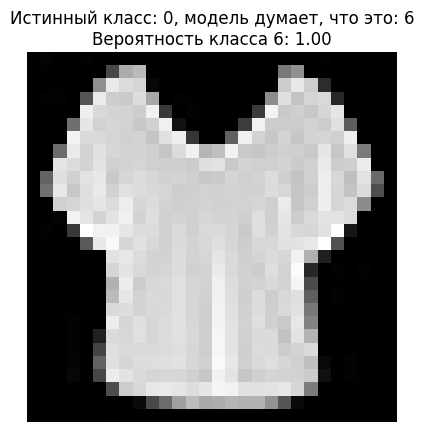

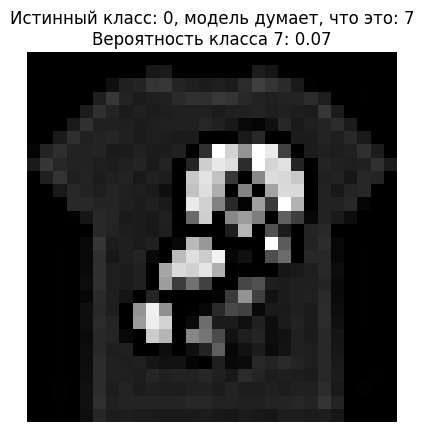

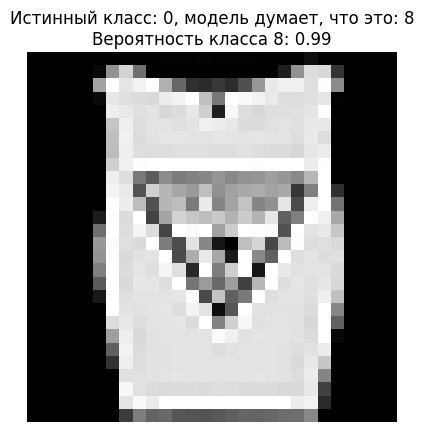

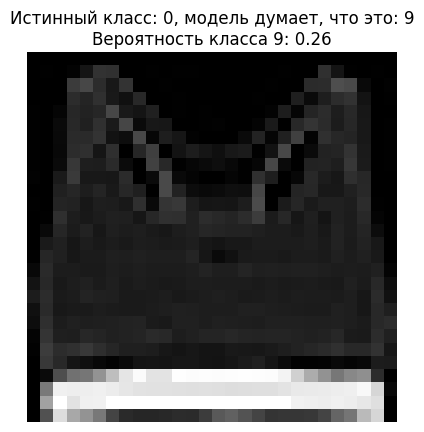

In [14]:
import matplotlib.pyplot as plt

def show_most_confused_examples(best_images):
    for (c, t), (img_tensor, prob) in best_images.items():
        plt.imshow(img_tensor.squeeze(), cmap='gray')
        plt.title(f"Истинный класс: {c}, модель думает, что это: {t}")
        plt.axis('off')
        plt.show()
show_most_confused_examples(best_images)
